# 0. SETUP

## 0.1. Módulos comuns

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection

from scipy.optimize import minimize

## 0.2. Parâmetros do problema

In [2]:
SCREEN_HEIGHT = 30 # The height of the screen that contains the overlapping windows in pixels
SCREEN_WIDTH = 30 # The width of the screen that contains the overlapping windows in pixels
CLUSTER_DISTANCE_FROM_SCREEN_CENTER = 7 # The distance from the clusters to the screen center in pixels
POINT_DISTANCE_FROM_CLUSTER = 5 # How far the points can be from the cluster in pixels

## 0.3. Preprocessamento dos parâmetros

In [3]:
SCREEN_CENTER = array([ floor(SCREEN_WIDTH/2), floor(SCREEN_HEIGHT/2) ])

# 1. PREPARAÇÃO DOS DADOS

Os vetores $P_j$ gerados possuem dimensão $4$: a posição $x$ e $y$ (coluna) da origem do retângulo (ponto superior esquerdo), a altura do retângulo $h$ e a largura $w$, de forma que $P_j=(x_j,y_j,h_j,w_j)$. A nivel de implementação, o ponto ainda possui a informação do cluster ao qual ele pertence.

## 1.1 Gerar Centros

In [4]:
n_groups = random.randint(3,7)
angle_between_points = (2.0 * pi / n_groups * arange(0 , n_groups)) # The array of the angle of each cluster w.r.t. the x-axis

clusters = transpose( # Each row is a pair x,y from each cluster
    array( [
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * cos( angle_between_points ) + SCREEN_CENTER[0],
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * sin( angle_between_points ) + SCREEN_CENTER[1]
    ] )
)

## 1.2 Gerar pontos ao redor dos centros

In [5]:
size_groups = random.randint(5, 16, n_groups)
points = zeros((sum(size_groups),5)) #

j = 0
for cluster_idx in range(n_groups):
    for idx in range(size_groups[cluster_idx]):
        # Point position
        points[j,:2] = clusters[cluster_idx] + random.randint(-POINT_DISTANCE_FROM_CLUSTER/2,POINT_DISTANCE_FROM_CLUSTER/2, 2)
        # Point dimension
        points[j,2:4] = random.randint(2,4,2)
        # cluster_information
        points[j,4] = cluster_idx
        j += 1

## 1.3 Mostrar os dados

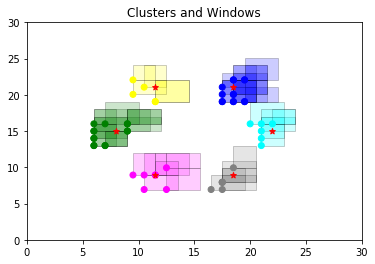

In [6]:
fig, ax = subplots(1)
ax.set_title("Clusters and Windows")
ax.set_xlim(0, SCREEN_WIDTH)
ax.set_ylim(0, SCREEN_HEIGHT)


# Draw Rectangles
rect_clusters_list = [[] for i in range(n_groups)]
for j in range(sum(size_groups)):
    point = points[j]
    rect = Rectangle((point[0], point[1]), point[2], point[3])
    rect_clusters_list[int(point[4])].append(rect)
color_list = ["cyan", "blue", "yellow", "green", "magenta", "gray", "black"]
#color_list = ["#8B1E3F", "#EB9D96", "#89BD9E", "#F0C987", "#DB4C40", "#18020C", "#6C5E64"]
for i in range(n_groups):
    rect_list = rect_clusters_list[i]
    pc = PatchCollection(rect_list, facecolor=color_list[i], edgecolor="k", alpha=0.2)
    ax.add_collection(pc)

# Plot points
colors_idx=points[:,4].astype('int32')
colors = [ color_list[color_idx] for color_idx in colors_idx]
scatter(points[:,0], points[:,1], c=colors)
    
# Plot Clusters
ax.scatter(clusters[:,0], clusters[:,1], c="red", marker="*")

# Display
show()

# 2. Modelagem Matemática


O problema se resume a maximizar $E(X) = (1-\alpha) E_O(X) + \alpha E_N(X) $, em que $X=(x_j, y_j)$ e $\alpha \in [0,1]$. $E_0$ e $E_N$ são as funções de energia de overlap e a de relação entre os vizinhos. Mais detalhes sobre as funções podem ser encontradas [neste link](https://ieeexplore.ieee.org/abstract/document/6629989).

In [7]:
def plus_operator(val):
    if val > 0:
        return val
    return 0.0

def O_ij(s_i, delta_s_i, s_j, delta_s_j):
    ret_val = 0
    if(s_i >= s_j):
        ret_val =  (1./(delta_s_j ** 4)) * plus_operator(delta_s_j ** 2 - (s_i - s_j) ** 2) ** 2
    else:
        ret_val =  (1./(delta_s_i ** 4)) * plus_operator(delta_s_i ** 2 - (s_i - s_j) ** 2) ** 2
    return ret_val

def E_O(X):
    X = reshape(X, points.shape)
    sum_e = 0
    n = points.shape[0]
    for i in range(points.shape[0]):
        point_i = points[i]
        # Horizontal
        x_i = point_i[0]
        h_i = point_i[2]
        # Vertical
        y_i = point_i[1]
        v_i = point_i[3]
        for j in range(i+1, points.shape[0]):
            point_j = points[j]
            # Horizontal
            x_j = point_j[0]
            h_j = point_j[2]
            overlapping_h = O_ij(x_i, h_i, x_j, h_j)
            # Vertical
            y_j = point_j[1]
            v_j = point_j[3]
            overlapping_v = O_ij(y_i, v_i, y_j, v_j)
            # Sum
            sum_e += overlapping_h * overlapping_v
    sum_e = 2.0 / (n * (n+1) ) * sum_e
    return sum_e

def E_N(X):
    return 

# 3. Solução Numérica

In [13]:
f = E_O # TODO: ADICIONAR E_N

## RESTRICOES
#### ATENCAO: AS RESTRICOES DE DESIGUALDADE NO SCIPY SAO O OPOSTO: SAO DO TIPO r(X) >= 0!!! AJUSTAR
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
x_min = 0
x_max = SCREEN_WIDTH
y_min = 0
y_max = SCREEN_HEIGHT

# r1: x_min-x_i <= 0 
#     <=> x_i - x_min >= 0
def constr_fun_1(X):
    """
    X is the matrix (N,5) of points.
    """
    X = reshape(X, points.shape)
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = x_min - X[i,0]
        constr[i] = X[i,0] - x_min
    return constr

# r2: x_i - x_max + h_i <= 0 
#     <=> x_max - x_i - h_i >= 0
def constr_fun_2(X):
    """
    X is the matrix (N,5) of points.
    """
    X = reshape(X, points.shape)
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = X[i,0] - x_max + X[i,2]
        constr[i] = x_max - X[i,0] - X[i,2]
    return constr

# r3: y_min-y_i <= 0 
#     <=> y_i - y_min >= 0
def constr_fun_3(X):
    """
    X is the matrix (N,5) of points.
    """
    X = reshape(X, points.shape)
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = X[i,1] -  y_min
    return constr

# r4: y_i - y_max + v_i <= 0
#     <=> y_max - y_i - v_i >= 0
def constr_fun_4(X):
    """
    X is the matrix (N,5) of points.
    """
    X = reshape(X, points.shape)
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = X[i,1] - x_max + X[i,3]
        constr[i] = x_max - X[i,1]  - X[i,3]
    return constr

cons = (
    {'type': 'ineq', 'fun':  constr_fun_1},
    {'type': 'ineq', 'fun':  constr_fun_2},
    {'type': 'ineq', 'fun':  constr_fun_3},
    {'type': 'ineq', 'fun':  constr_fun_4},
)

res = minimize(f, points, method='SLSQP', constraints=cons)
print(res["x"])

[21.         15.          3.          2.          0.         21.
 13.          2.          3.          0.         20.         16.
  3.          3.          0.         21.         14.          2.
  3.          0.         22.         16.          2.          2.
  0.         21.         16.          3.          2.          0.
 19.5        19.06217783  3.          2.          1.         19.5
 22.06217783  2.          2.          1.         17.5        21.06217783
  3.          2.          1.         19.5        19.06217783  2.
  3.          1.         18.5        22.06217783  2.          2.
  1.         17.5        19.06217783  3.          3.          1.
 17.5        19.06217783  3.          3.          1.         17.5
 20.06217783  2.          2.          1.         18.5        20.06217783
  3.          2.          1.         18.5        19.06217783  2.
  2.          1.         18.5        19.06217783  2.          3.
  1.         18.5        22.06217783  3.          2.          1.
 18.5  

# 4. Visualização dos Resultados

# 5. Elaboração de relatório